## Analyzing FEMA's National Flood Insurance Program (NFIP) Data With DuckDB
Author: Mark Bauer

## Introduction

The FEMA National Flood Insurance Program (NFIP) website offers a trove of valuable information. Among its highlights is the [Flood Insurance Data and Analytics](https://nfipservices.floodsmart.gov/reports-flood-insurance-data) section, featuring data visualizations, tables, and reports. This project was inspired by these resources, particularly the Financial Losses by State and Policy, and Loss Statistics by Flood Zone Excel files.

Additionally, this analysis focuses solely on the NFIP Claims dataset, mainly because of the availability of the dataset as a Parquet file. Given the size of this dataset, it was a good opportunity to utilize and learn more about [DuckDB](https://duckdb.org/).

In [1]:
# import libraries
import duckdb
import pandas as pd

In [2]:
print("duckdb version: {}".format(duckdb.__version__))

duckdb version: 0.10.0


In [3]:
# create a DuckDB database instance
con = duckdb.connect(config={"allow_unsigned_extensions": "true"})

# assign the path of the httpfs extension. Note: I built the extension from source but you
# should review the extensions guide on DuckDB's official documentation.
path = "../duckdb/build/release/repository/v0.10.0/osx_amd64/httpfs.duckdb_extension"

# install and load extension
con.install_extension(path)
con.load_extension(path)

In [4]:
%reload_ext sql
%sql con --alias duckdb

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

## Create Table Using DuckDB

In [5]:
# create table of the claims dataset
con.sql(
    """
    CREATE TABLE claims AS
    FROM read_parquet('data/FimaNfipClaims.parquet')
    """
)

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM claims").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│    2609973 │
└────────────┘



## Examine and Describe Data Set

In [6]:
# preview data
con.sql("SELECT * FROM claims LIMIT 10").show()

┌──────────────────────┬──────────────────────┬──────────────────────┬───┬──────────────────────┬──────────┬───────────┐
│          id          │ agricultureStructu…  │       asOfDate       │ … │ censusBlockGroupFips │ latitude │ longitude │
│       varchar        │       boolean        │      timestamp       │   │       varchar        │  double  │  double   │
├──────────────────────┼──────────────────────┼──────────────────────┼───┼──────────────────────┼──────────┼───────────┤
│ 61a2811b-a92b-486d…  │ false                │ 2020-12-11 16:25:4…  │ … │ 010030114072         │     30.3 │     -87.7 │
│ b9123f27-fa0e-4097…  │ false                │ 2020-11-13 14:50:3…  │ … │ 010030114073         │     30.3 │     -87.7 │
│ 9de3700b-bbbd-408c…  │ false                │ 2022-04-21 19:56:4…  │ … │ 010010204001         │     32.5 │     -86.4 │
│ c2450563-0de0-40df…  │ false                │ 2020-03-09 19:28:2…  │ … │ 010010204001         │     32.5 │     -86.4 │
│ 6b13ea94-ef8d-428a…  │ false  

In [7]:
# examine column metadata and assign as a pandas df
describe_df = con.sql("DESCRIBE claims").df()

describe_df

,column_name,column_type,null,key,default,extra
0,id,VARCHAR,YES,None,None,None
1,agricultureStructureIndicator,BOOLEAN,YES,None,None,None
2,asOfDate,TIMESTAMP,YES,None,None,None
3,basementEnclosureCrawlspaceType,SMALLINT,YES,None,None,None
4,policyCount,SMALLINT,YES,None,None,None
...,...,...,...,...,...,...
68,countyCode,VARCHAR,YES,None,None,None
69,censusTract,VARCHAR,YES,None,None,None
70,censusBlockGroupFips,VARCHAR,YES,None,None,None
71,latitude,DOUBLE,YES,None,None,None


In [8]:
# examine each column in sections because of large number of columns
describe_df.iloc[:25, :]

,column_name,column_type,null,key,default,extra
0,id,VARCHAR,YES,None,None,None
1,agricultureStructureIndicator,BOOLEAN,YES,None,None,None
2,asOfDate,TIMESTAMP,YES,None,None,None
3,basementEnclosureCrawlspaceType,SMALLINT,YES,None,None,None
4,policyCount,SMALLINT,YES,None,None,None
5,crsClassificationCode,SMALLINT,YES,None,None,None
6,dateOfLoss,DATE,YES,None,None,None
7,elevatedBuildingIndicator,BOOLEAN,YES,None,None,None
8,elevationCertificateIndicator,VARCHAR,YES,None,None,None
9,elevationDifference,DOUBLE,YES,None,None,None


In [9]:
describe_df.iloc[25:50, :]

,column_name,column_type,null,key,default,extra
25,postFIRMConstructionIndicator,BOOLEAN,YES,None,None,None
26,rateMethod,VARCHAR,YES,None,None,None
27,smallBusinessIndicatorBuilding,BOOLEAN,YES,None,None,None
28,totalBuildingInsuranceCoverage,BIGINT,YES,None,None,None
29,totalContentsInsuranceCoverage,BIGINT,YES,None,None,None
30,yearOfLoss,SMALLINT,YES,None,None,None
31,primaryResidenceIndicator,BOOLEAN,YES,None,None,None
32,buildingDamageAmount,BIGINT,YES,None,None,None
33,buildingDeductibleCode,VARCHAR,YES,None,None,None
34,netBuildingPaymentAmount,DOUBLE,YES,None,None,None


In [10]:
describe_df.iloc[50:, :]

,column_name,column_type,null,key,default,extra
50,netIccPaymentAmount,DOUBLE,YES,None,None,None
51,nfipRatedCommunityNumber,VARCHAR,YES,None,None,None
52,nfipCommunityNumberCurrent,VARCHAR,YES,None,None,None
53,nfipCommunityName,VARCHAR,YES,None,None,None
54,nonPaymentReasonContents,VARCHAR,YES,None,None,None
55,nonPaymentReasonBuilding,VARCHAR,YES,None,None,None
56,numberOfUnits,INTEGER,YES,None,None,None
57,buildingReplacementCost,BIGINT,YES,None,None,None
58,contentsReplacementCost,BIGINT,YES,None,None,None
59,replacementCostBasis,VARCHAR,YES,None,None,None


## Summary Statistics

In [11]:
# calculate summary statistics of each column
summarize_df = con.sql("SUMMARIZE claims").df()

summarize_df

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,id,VARCHAR,000006af-51d1-453e-8c06-5791060175ab,fffffeef-b65f-4405-ab4e-60257523aa4f,2662059,None,None,None,None,None,2609973,0.00
1,agricultureStructureIndicator,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
2,asOfDate,TIMESTAMP,2019-09-19 06:12:43.388,2024-05-01 20:18:36.77,425022,None,None,None,None,None,2609973,0.00
3,basementEnclosureCrawlspaceType,SMALLINT,0,4,4,1.228374267022299,1.0566934718476708,0,1,2,2609973,70.18
4,policyCount,SMALLINT,1,1090,398,1.2797094069555508,6.673514288571852,1,1,1,2609973,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
68,countyCode,VARCHAR,01001,78030,2942,None,None,None,None,None,2609973,2.38
69,censusTract,VARCHAR,01001020100,78030961200,54666,None,None,None,None,None,2609973,5.27
70,censusBlockGroupFips,VARCHAR,010010201001,780309612002,110152,None,None,None,None,None,2609973,5.27
71,latitude,DOUBLE,-36.0,69.9,335,33.869589599355244,5.826147648469411,29.89249373665167,30.973717101481455,39.74536512588599,2609973,1.53


In [12]:
# examine each column in sections because of large number of columns
summarize_df.iloc[:25, :]

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,id,VARCHAR,000006af-51d1-453e-8c06-5791060175ab,fffffeef-b65f-4405-ab4e-60257523aa4f,2662059,None,None,None,None,None,2609973,0.00
1,agricultureStructureIndicator,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
2,asOfDate,TIMESTAMP,2019-09-19 06:12:43.388,2024-05-01 20:18:36.77,425022,None,None,None,None,None,2609973,0.00
3,basementEnclosureCrawlspaceType,SMALLINT,0,4,4,1.228374267022299,1.0566934718476708,0,1,2,2609973,70.18
4,policyCount,SMALLINT,1,1090,398,1.2797094069555508,6.673514288571852,1,1,1,2609973,0.00
5,crsClassificationCode,SMALLINT,1,10,10,6.848428755453079,1.5049489596950087,5,7,8,2609973,82.30
6,dateOfLoss,DATE,1978-01-01,2024-05-01,16687,None,None,None,None,None,2609973,0.00
7,elevatedBuildingIndicator,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
8,elevationCertificateIndicator,VARCHAR,1,E,9,None,None,None,None,None,2609973,77.41
9,elevationDifference,DOUBLE,-9989.0,998.0,370,1.2817296900477881,29.36265619963506,0.0,1.0,2.7602220635827566,2609973,72.86


In [13]:
summarize_df.iloc[25:50, :]

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
25,postFIRMConstructionIndicator,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
26,rateMethod,VARCHAR,1,W,22,None,None,None,None,None,2609973,1.90
27,smallBusinessIndicatorBuilding,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
28,totalBuildingInsuranceCoverage,BIGINT,0,243903000,11951,166889.41585940993,1228597.5907276461,39009,99503,210046,2609973,0.00
29,totalContentsInsuranceCoverage,BIGINT,0,6000000,3048,30733.689877477143,50621.54742463344,0,11526,44940,2609973,0.00
30,yearOfLoss,SMALLINT,1978,2024,47,2002.1435083811211,12.501478526205851,1993,2005,2012,2609973,0.00
31,primaryResidenceIndicator,BOOLEAN,false,true,2,None,None,None,None,None,2609973,0.00
32,buildingDamageAmount,BIGINT,0,927700000,201765,36311.10027419284,814576.3551108028,3436,11201,40113,2609973,22.40
33,buildingDeductibleCode,VARCHAR,0,H,15,None,None,None,None,None,2609973,11.99
34,netBuildingPaymentAmount,DOUBLE,-162432.16,10000000.0,1280807,24695.035330748677,59271.29895574302,2.423920318484294,4705.328589574692,24832.640018137696,2609973,0.00


In [14]:
summarize_df.iloc[50:, :]

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
50,netIccPaymentAmount,DOUBLE,-6450.0,60000.0,8708,361.25060566526935,3098.8927849140696,0.0,0.0,0.0,2609973,0.00
51,nfipRatedCommunityNumber,VARCHAR,000000,999999,16288,None,None,None,None,None,2609973,0.00
52,nfipCommunityNumberCurrent,VARCHAR,0000,815000,11987,None,None,None,None,None,2609973,72.96
53,nfipCommunityName,VARCHAR,ABBEVILLE COUNTY *,"ZUMBRO FALLS, CITY OF",9794,None,None,None,None,None,2609973,72.43
54,nonPaymentReasonContents,VARCHAR,01,99,23,None,None,None,None,None,2609973,68.43
55,nonPaymentReasonBuilding,VARCHAR,01,99,23,None,None,None,None,None,2609973,77.62
56,numberOfUnits,INTEGER,0,99999,445,1.3626484479940102,66.1785648759575,1,1,1,2609973,0.11
57,buildingReplacementCost,BIGINT,0,9999000000,443562,8613520.156327939,235672086.9084633,0,120426,223043,2609973,22.40
58,contentsReplacementCost,BIGINT,0,20000000,8867,2802.1066546353063,46646.03669656624,0,0,0,2609973,59.11
59,replacementCostBasis,VARCHAR,A,R,2,None,None,None,None,None,2609973,7.27


In [15]:
# examine columns with high null percentage
(summarize_df
 .sort_values(by='null_percentage', ascending=False)
 .loc[:, ['column_name', 'null_percentage']]
 .head(10)
)

,column_name,null_percentage
45,floodCharacteristicsIndicator,98.47
43,eventDesignationNumber,96.01
5,crsClassificationCode,82.30
14,lowestAdjacentGrade,81.38
55,nonPaymentReasonBuilding,77.62
8,elevationCertificateIndicator,77.41
15,lowestFloorElevation,76.24
10,baseFloodElevation,75.68
62,floodZoneCurrent,73.00
52,nfipCommunityNumberCurrent,72.96


### Amount Paid on Claims Summary Statistics

In [16]:
# examine summary statisitics on amount claims paid columns
col_names = [
    'amountPaidOnBuildingClaim',
    'amountPaidOnContentsClaim',
    'amountPaidOnIncreasedCostOfComplianceClaim'
]

cols = [
    'column_name', 'min', 'max', 'avg', 'std',
    'q25', 'q50', 'q75', 'null_percentage'
]

(summarize_df
 .loc[summarize_df['column_name'].isin(col_names), cols]
 .set_index('column_name')
 .reindex(col_names)
 .T
)

column_name,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim
min,-162432.16,-41276.32,-6450.0
max,10000000.0,757048.95,60000.0
avg,31499.400109979106,7114.899395276431,461.93919845427996
std,65354.077113819,22202.62370893099,3497.7930841075827
q25,2326.1777286875226,0.0,0.0
q50,9625.300076617363,0.0,0.0
q75,36557.62524205478,4828.180381487528,0.0
null_percentage,21.5,21.5,21.5


### Building Damage, Values, and Replacement Costs Summary Statistics

In [17]:
# examine summary statisitics on building damage amounts, property values and replacement costs columns
col_names = [
    'buildingDamageAmount',
    'netBuildingPaymentAmount',
    'buildingPropertyValue',
    'buildingReplacementCost'
    
]

cols = [
    'column_name', 'min', 'max', 'avg', 'std',
    'q25', 'q50', 'q75', 'null_percentage'
]

(summarize_df
 .loc[summarize_df['column_name'].isin(col_names), cols]
 .set_index('column_name')
 .reindex(col_names)
 .T
)

column_name,buildingDamageAmount,netBuildingPaymentAmount,buildingPropertyValue,buildingReplacementCost
min,0,-162432.16,0,0
max,927700000,10000000.0,9950000000,9999000000
avg,36311.10027419284,24695.035330748677,7185179.093795381,8613520.156327939
std,814576.3551108028,59271.29895574302,200484954.57393038,235672086.9084633
q25,3436,2.423920318484294,60699,0
q50,11201,4705.328589574692,109472,120426
q75,40113,24832.640018137696,189160,223043
null_percentage,22.4,0.0,22.4,22.4


### Contents Damage, Values, and Replacement Costs Summary Statistics

In [18]:
# examine summary statisitics on contents amounts, property values and replacement costs columns
col_names = [
    'contentsDamageAmount',
    'netContentsPaymentAmount',
    'contentsPropertyValue',
    'contentsReplacementCost'
    
]

cols = [
    'column_name', 'min', 'max', 'avg', 'std',
    'q25', 'q50', 'q75', 'null_percentage'
]

(summarize_df
 .loc[summarize_df['column_name'].isin(col_names), cols]
 .set_index('column_name')
 .reindex(col_names)
 .T
)

column_name,contentsDamageAmount,netContentsPaymentAmount,contentsPropertyValue,contentsReplacementCost
min,0,-41276.32,-1,0
max,19230507,757048.95,281895323,20000000
avg,18359.902942019133,5563.0051842490975,31187.93643040255,2802.1066546353063
std,85635.12448811435,19864.170528635423,488975.7447223464,46646.03669656624
q25,1634,0.0,0,0
q50,5708,0.0,0,0
q75,18577,2245.3343260598404,19171,0
null_percentage,59.08,0.0,59.08,59.11


### Elevation and Water Depth Summary Statistics

In [19]:
# examine summary statisitics on elevation and water depth columns
col_names = [
    'lowestAdjacentGrade',
    'lowestFloorElevation',
    'baseFloodElevation',
    'elevationDifference',    
    'waterDepth'
    
]

cols = [
    'column_name', 'min', 'max', 'avg', 'std',
    'q25', 'q50', 'q75', 'null_percentage'
]

(summarize_df
 .loc[summarize_df['column_name'].isin(col_names), cols]
 .set_index('column_name')
 .reindex(col_names)
 .T
)

column_name,lowestAdjacentGrade,lowestFloorElevation,baseFloodElevation,elevationDifference,waterDepth
min,-99999.9,-6002.0,-9999.0,-9989.0,-999
max,9998.9,9998.0,9998.0,998.0,999
avg,46.20236141573817,117.60637039139336,123.80080997365577,1.2817296900477881,4.302038514059302
std,1570.0474871017354,715.7659733011728,751.3180224953247,29.36265619963506,16.433883166615644
q25,2.9693858470592844,6.416466323795986,6.634789866395541,0.0,0
q50,6.093059970912654,10.182667237239983,9.0,1.0,1
q75,10.962958478181855,17.36333541549381,14.077574563956496,2.7602220635827566,2
null_percentage,81.38,76.24,75.68,72.86,8.5


<AxesSubplot:title={'center':"'lowestAdjacentGrade' from 'claims'"}, ylabel='lowestAdjacentGrade'>

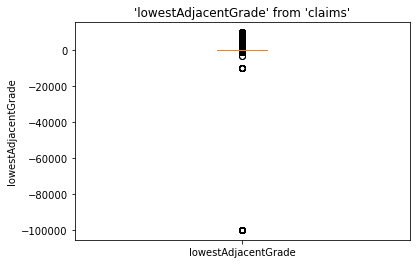

In [20]:
%sqlplot boxplot -t claims -c lowestAdjacentGrade

<AxesSubplot:title={'center':"'lowestFloorElevation' from 'claims'"}, ylabel='lowestFloorElevation'>

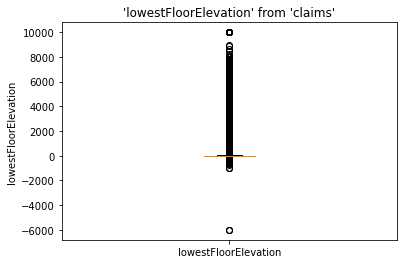

In [21]:
%sqlplot boxplot -t claims -c lowestFloorElevation

<AxesSubplot:title={'center':"'baseFloodElevation' from 'claims'"}, ylabel='baseFloodElevation'>

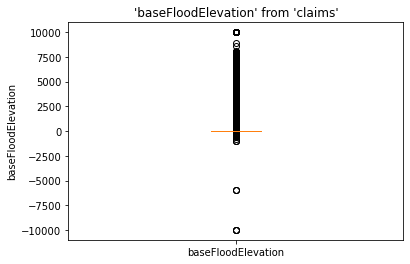

In [22]:
%sqlplot boxplot -t claims -c baseFloodElevation

<AxesSubplot:title={'center':"'elevationDifference' from 'claims'"}, ylabel='elevationDifference'>

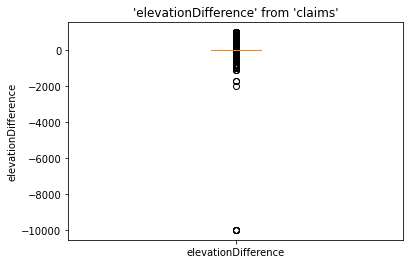

In [23]:
%sqlplot boxplot -t claims -c elevationDifference

<AxesSubplot:title={'center':"'waterDepth' from 'claims'"}, ylabel='waterDepth'>

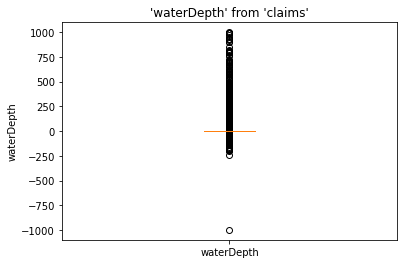

In [24]:
%sqlplot boxplot -t claims -c waterDepth

## Analysis

In [25]:
# preview column names to use for Analysis section
(con
 .sql("SELECT * FROM claims LIMIT 10")
 .df()
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 73 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   id                                          10 non-null     object        
 1   agricultureStructureIndicator               10 non-null     bool          
 2   asOfDate                                    10 non-null     datetime64[ns]
 3   basementEnclosureCrawlspaceType             3 non-null      float64       
 4   policyCount                                 10 non-null     int16         
 5   crsClassificationCode                       7 non-null      float64       
 6   dateOfLoss                                  10 non-null     datetime64[ns]
 7   elevatedBuildingIndicator                   10 non-null     bool          
 8   elevationCertificateIndicator               1 non-null      object        
 9   elevationDiff

### Total Claims

In [26]:
con.sql(
    """
    SELECT
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim, 
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    """
)

┌─────────────┬───────────────┬───────────────┬────────────────────────────────┐
│ TotalClaim  │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│    int64    │     int64     │     int64     │             int64              │
├─────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ 80057600349 │   64534521973 │   14576678596 │                      946399781 │
└─────────────┴───────────────┴───────────────┴────────────────────────────────┘

### Total Claims by State

In [27]:
con.sql(
    """
    SELECT
        state,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim, 
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
    """
)

┌─────────┬─────────────┬───────────────┬───────────────┬────────────────────────────────┐
│  state  │ TotalClaim  │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│ varchar │    int64    │     int64     │     int64     │             int64              │
├─────────┼─────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ LA      │ 20838923032 │   16431635833 │    4129930893 │                      277356306 │
│ TX      │ 17083042210 │   13136650534 │    3888589851 │                       57801825 │
│ FL      │ 11166770151 │    9458190896 │    1671373622 │                       37205633 │
│ NJ      │  6465642998 │    5345477364 │     869804214 │                      250361420 │
│ NY      │  5714558618 │    4944383614 │     717516208 │                       52658796 │
│ MS      │  3121617364 │    2385247785 │     675466706 │                       60902873 │
│ NC      │  2002988094 │    1692155613 │     273870198 │                       36962283 │

### Total Claims by State for Fiscal Year 2024

In [28]:
con.sql(
    """
    SELECT
        state, 
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    WHERE dateOfLoss between '2023-10-01' AND '2024-09-30'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬───────────────┬───────────────┬────────────────────────────────┐
│  state  │ TotalClaim │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│ varchar │   int64    │     int64     │     int64     │             int64              │
├─────────┼────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ ME      │   28553103 │      26108035 │       2435049 │                          10019 │
│ NY      │   23722092 │      21998415 │       1723677 │                              0 │
│ FL      │   23229815 │      21388638 │       1841177 │                              0 │
│ CA      │   21744654 │      20373883 │       1370772 │                              0 │
│ NJ      │   19296081 │      17150204 │       2145877 │                              0 │
│ RI      │    8546350 │       8129389 │        416960 │                              0 │
│ SC      │    8444517 │       7837273 │        607244 │                              0 │
│ NH      

### Total Claims by County

In [29]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬────────────┬───────────────┬───────────────┬────────────────────────────────┐
│  state  │ countyCode │ TotalClaim │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│ varchar │  varchar   │   int64    │     int64     │     int64     │             int64              │
├─────────┼────────────┼────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ TX      │ 48201      │ 8705456456 │    6756752295 │    1928687883 │                       20016278 │
│ LA      │ 22071      │ 7294446959 │    5890983538 │    1292969906 │                      110493515 │
│ LA      │ 22051      │ 3527668438 │    2619027797 │     847127476 │                       61513166 │
│ FL      │ 12071      │ 3333790855 │    2975824827 │     356154969 │                        1811059 │
│ NJ      │ 34029      │ 2607850866 │    2160793243 │     275246922 │                      171810701 │
│ TX      │ 48167      │ 2456431694 │    1887282122 │     548178802 │    

### Total Claims by Flood Event

In [30]:
con.sql(
    """
    SELECT
        floodEvent,
        yearOfLoss,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS ICCClaim
    FROM claims
    WHERE floodEvent NOT NULL
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌──────────────────────────┬────────────┬─────────────┬───────────────┬───────────────┬───────────┐
│        floodEvent        │ yearOfLoss │ TotalClaim  │ BuildingClaim │ ContentsClaim │ ICCClaim  │
│         varchar          │   int16    │    int64    │     int64     │     int64     │   int64   │
├──────────────────────────┼────────────┼─────────────┼───────────────┼───────────────┼───────────┤
│ Hurricane Katrina        │       2005 │ 16261697056 │   12659081935 │    3360020221 │ 242594900 │
│ Hurricane Harvey         │       2017 │  9055446500 │    6925357028 │    2115077279 │  15012193 │
│ Hurricane Sandy          │       2012 │  8956175518 │    7707763973 │     951584858 │ 296826687 │
│ Hurricane Ian            │       2022 │  4653622925 │    4132266664 │     519501586 │   1854675 │
│ Hurricane Ike            │       2008 │  2702511916 │    2073801567 │     577791589 │  50918760 │
│ Mid-summer severe storms │       2016 │  2533368883 │    2175216439 │     347263588 │  10888856 │


In [31]:
con.sql(
    """
    SELECT
        floodEvent,
        yearOfLoss,
        state,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS ICCClaim
    FROM claims
    WHERE floodEvent NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    LIMIT 20
    """
)

┌──────────────────────────┬────────────┬─────────┬─────────────┬───────────────┬───────────────┬───────────┐
│        floodEvent        │ yearOfLoss │  state  │ TotalClaim  │ BuildingClaim │ ContentsClaim │ ICCClaim  │
│         varchar          │   int16    │ varchar │    int64    │     int64     │     int64     │   int64   │
├──────────────────────────┼────────────┼─────────┼─────────────┼───────────────┼───────────────┼───────────┤
│ Hurricane Katrina        │       2005 │ LA      │ 13347164644 │   10441743931 │    2721451049 │ 183969663 │
│ Hurricane Harvey         │       2017 │ TX      │  9040104864 │    6912536831 │    2112555840 │  15012193 │
│ Hurricane Ian            │       2022 │ FL      │  4608058052 │    4090976598 │     515346779 │   1734675 │
│ Hurricane Sandy          │       2012 │ NJ      │  4372117786 │    3673312870 │     457640033 │ 241164883 │
│ Hurricane Sandy          │       2012 │ NY      │  4213915671 │    3702363706 │     465358598 │  46193367 │
│ Mid-summ

### Total Claims by Flood Zone

In [32]:
con.sql(
    """
    SELECT
        ratedFloodZone as ratedFloodZone,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
    """
)

┌────────────────┬─────────────┬───────────────┬───────────────┬────────────────────────────────┐
│ ratedFloodZone │ TotalClaim  │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│    varchar     │    int64    │     int64     │     int64     │             int64              │
├────────────────┼─────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ AE             │ 35111157725 │   29248455727 │    5349491157 │                      513210841 │
│ X              │ 13293684798 │   10258338304 │    3006893246 │                       28453247 │
│ B              │  3826003058 │    2835227048 │     971988985 │                       18787025 │
│ A              │  3097345563 │    2457942866 │     602004885 │                       37397812 │
│ C              │  2851078461 │    2117465674 │     723537437 │                       10075351 │
│ A04            │  2185900631 │    1800894098 │     364396806 │                       20609726 │
│ A03            │  

### Total Claims by Occupancy Type

In [33]:
con.sql(
    """
    SELECT
        occupancyType,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
    """
)

┌───────────────┬─────────────┬───────────────┬───────────────┬────────────────────────────────┐
│ occupancyType │ TotalClaim  │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│     int16     │    int64    │     int64     │     int64     │             int64              │
├───────────────┼─────────────┼───────────────┼───────────────┼────────────────────────────────┤
│             1 │ 58068945128 │   46435050309 │   10743686447 │                      890208372 │
│             4 │  6399065992 │    4292302635 │    2095965716 │                       10797641 │
│             3 │  4374189293 │    4228633027 │     138249314 │                        7306952 │
│             2 │  3730087287 │    3407331381 │     287664029 │                       35091878 │
│             6 │  3358494979 │    2511223292 │     845669820 │                        1601866 │
│            11 │  2491648290 │    2158598189 │     331902381 │                        1147721 │
│            15 │   861271847 

### Total Claims by Flood Zone and Occupancy Type

In [34]:
con.sql(
    """
    SELECT
        ratedFloodZone,
        occupancyType,
        ROUND(
            SUM(amountPaidOnBuildingClaim)
            + SUM(amountPaidOnContentsClaim)
            + SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS TotalClaim,  
        ROUND(SUM(amountPaidOnBuildingClaim), 0)::INT64 AS BuildingClaim,
        ROUND(SUM(amountPaidOnContentsClaim), 0)::INT64 AS ContentsClaim, 
        ROUND(SUM(amountPaidOnIncreasedCostOfComplianceClaim), 0)::INT64 AS IncreasedCostOfComplianceClaim
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌────────────────┬───────────────┬─────────────┬───────────────┬───────────────┬────────────────────────────────┐
│ ratedFloodZone │ occupancyType │ TotalClaim  │ BuildingClaim │ ContentsClaim │ IncreasedCostOfComplianceClaim │
│    varchar     │     int16     │    int64    │     int64     │     int64     │             int64              │
├────────────────┼───────────────┼─────────────┼───────────────┼───────────────┼────────────────────────────────┤
│ AE             │             1 │ 24280260327 │   19986111836 │    3803579791 │                      490568700 │
│ X              │             1 │ 10707127507 │    8229644367 │    2450235094 │                       27248046 │
│ B              │             1 │  2959535823 │    2183555532 │     758744816 │                       17235475 │
│ A              │             1 │  2380346133 │    1945172272 │     399071426 │                       36102435 │
│ AE             │             3 │  2150998205 │    2096708194 │      52374043 │        

## Building Damage Amount, Property Values, and Building Replacement Costs

In [35]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        SUM(buildingDamageAmount) AS buildingDamageAmount
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬──────────────────────┐
│  state  │ countyCode │ buildingDamageAmount │
│ varchar │  varchar   │        int128        │
├─────────┼────────────┼──────────────────────┤
│ LA      │ 22071      │           7350659281 │
│ TX      │ 48201      │           7021786026 │
│ FL      │ 12071      │           2874152654 │
│ LA      │ 22051      │           2841549181 │
│ NJ      │ 34029      │           2225941045 │
│ LA      │ 22087      │           2119468674 │
│ NY      │ 36059      │           2002211870 │
│ TX      │ 48167      │           1993090966 │
│ LA      │ 22103      │           1505719848 │
│ MS      │ 28047      │           1281883132 │
│ LA      │ 22033      │           1156790671 │
│ NY      │ 36103      │           1008267857 │
│ NC      │ 37039      │            928053680 │
│ TX      │ 48245      │            863658029 │
│ FL      │ 12021      │            824258070 │
│ NJ      │ 34025      │            821891713 │
│ NC      │ 37129      │            7406

In [36]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        ROUND(AVG(buildingDamageAmount), 0)::INT AS averageBuildingDamageAmount
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬─────────────────────────────┐
│  state  │ countyCode │ averageBuildingDamageAmount │
│ varchar │  varchar   │            int32            │
├─────────┼────────────┼─────────────────────────────┤
│ NC      │ 37039      │                    23201342 │
│ MI      │ 26019      │                     2017161 │
│ IA      │ 19103      │                      251542 │
│ MS      │ 28089      │                      248306 │
│ TX      │ 48229      │                      246315 │
│ TX      │ 48103      │                      227145 │
│ NC      │ 37183      │                      204666 │
│ NY      │ 36061      │                      181777 │
│ KY      │ 21045      │                      166985 │
│ SD      │ 46021      │                      163208 │
│ MS      │ 28073      │                      160428 │
│ NE      │ 31059      │                      155000 │
│ MN      │ 27075      │                      136236 │
│ OK      │ 40109      │                      127062 │
│ AR      

In [37]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        SUM(buildingPropertyValue) AS buildingPropertyValue
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬───────────────────────┐
│  state  │ countyCode │ buildingPropertyValue │
│ varchar │  varchar   │        int128         │
├─────────┼────────────┼───────────────────────┤
│ FL      │ 12086      │         3845514973029 │
│ TX      │ 48201      │         3205177952009 │
│ FL      │ 12011      │          599535536455 │
│ LA      │ 22071      │          569325310461 │
│ LA      │ 22051      │          370117379618 │
│ LA      │ 22033      │          319539388199 │
│ LA      │ 22103      │          299509352066 │
│ MS      │ 28047      │          244193875137 │
│ MS      │ 28059      │          219305509604 │
│ TX      │ 48167      │          202733066869 │
│ AL      │ 01097      │          201930785920 │
│ AL      │ 01003      │          197333005949 │
│ FL      │ 12071      │          194071048135 │
│ GA      │ 13051      │          187768637543 │
│ FL      │ 12101      │          132674843692 │
│ TX      │ 48039      │          121603663822 │
│ TX      │ 48245   

In [38]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        ROUND(AVG(buildingPropertyValue), 0)::INT AS averageBuildingPropertyValue
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬──────────────────────────────┐
│  state  │ countyCode │ averageBuildingPropertyValue │
│ varchar │  varchar   │            int32             │
├─────────┼────────────┼──────────────────────────────┤
│ TX      │ 48319      │                   1075820643 │
│ GA      │ 13303      │                    875098751 │
│ FL      │ 12039      │                    346718569 │
│ TN      │ 47059      │                    224258838 │
│ MN      │ 27047      │                    183677166 │
│ TN      │ 47001      │                    128031664 │
│ FL      │ 12086      │                    103633141 │
│ IA      │ 19097      │                     95058762 │
│ VA      │ 51175      │                     91906219 │
│ FL      │ 12121      │                     82119751 │
│ MO      │ 29069      │                     75069260 │
│ IN      │ 18025      │                     70678160 │
│ GA      │ 13277      │                     62770306 │
│ KY      │ 21197      │                     607

In [39]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        SUM(buildingReplacementCost) AS buildingReplacementCost
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬─────────────────────────┐
│  state  │ countyCode │ buildingReplacementCost │
│ varchar │  varchar   │         int128          │
├─────────┼────────────┼─────────────────────────┤
│ FL      │ 12086      │           4525773976940 │
│ TX      │ 48201      │           4236477640925 │
│ FL      │ 12011      │            668646277370 │
│ LA      │ 22071      │            615874845528 │
│ LA      │ 22103      │            379763277683 │
│ LA      │ 22033      │            357578170320 │
│ LA      │ 22051      │            351731162611 │
│ MS      │ 28047      │            292260217707 │
│ TX      │ 48167      │            261432126466 │
│ MS      │ 28059      │            254262990675 │
│ AL      │ 01097      │            240570830401 │
│ AL      │ 01003      │            233399897230 │
│ FL      │ 12071      │            224130115253 │
│ GA      │ 13051      │            222226017338 │
│ TX      │ 48245      │            177753590517 │
│ TX      │ 48039      │       

In [40]:
con.sql(
    """
    SELECT
        state,
        countyCode,
        ROUND(AVG(buildingReplacementCost), 0)::INT AS averageBuildingReplacementCost
    FROM claims
    GROUP BY 1, 2
    ORDER BY 3 DESC
    LIMIT 20
    """
)

┌─────────┬────────────┬────────────────────────────────┐
│  state  │ countyCode │ averageBuildingReplacementCost │
│ varchar │  varchar   │             int32              │
├─────────┼────────────┼────────────────────────────────┤
│ TX      │ 48319      │                     1195396433 │
│ GA      │ 13303      │                      875133025 │
│ FL      │ 12039      │                      380981892 │
│ TN      │ 47059      │                      260736416 │
│ MN      │ 27047      │                      208675508 │
│ TN      │ 47001      │                      155942955 │
│ VA      │ 51175      │                      135374733 │
│ FL      │ 12086      │                      121965505 │
│ IA      │ 19097      │                      113161328 │
│ FL      │ 12121      │                       89671430 │
│ MO      │ 29069      │                       88320487 │
│ IN      │ 18025      │                       88289775 │
│ VA      │ 51620      │                       81528046 │
│ NY      │ 36